# CSC 522 Group 8 Project

## Professor Insights: Clustering Quality and Difficulty Across NCSU Colleges

This project is a data science project that uses the [RateMyProfessors](https://www.ratemyprofessors.com/) website to scrape data on professors and their ratings. The data is then used to cluster the professors based on their quality and difficulty ratings, and identify similarities and differences of the rating distributions across colleges.

### 1. Data Aquisition
This cell scrapes the most up-to-date data on all NCSU professors on RateMyProfessors and saves the data to a JSON file. This takes less than 30 seconds to execute, and does not need to be re-run if the file already exists.

In [ ]:
import json
from ratemyprofessors import RateMyProfessorsAPI


api = RateMyProfessorsAPI()
school = api.search_school("NCSU")

professors = []

# Get all NCSU professors on RateMyProfessors
cursor = ""
while True:
    result = api.search_teachers(school['id'], "", limit=1000, cursor=cursor)
    if not result['teachers']:
        break
    cursor = result['end_cursor']
    for professor in result['teachers']:
        del professor['school']
    professors.extend(result['teachers'])

print(len(professors), 'professors fetched')

# Filter out professors with no ratings
professors = list(filter(lambda professor: professor['num_ratings'] > 0, professors))

print(len(professors), 'professors with ratings')

# Sort by most ratings in descending order    
professors.sort(key=lambda professor: professor['num_ratings'], reverse=True)

with open("data/professors.json", "w") as file:
    json.dump(professors, file, indent=2)

This cell scrapes distributions for every course from the gradient database, calculating the average GPA for each section. It is designed to be able to be computed in multiple executions in case the authorization tokens expire before the scraping is complete. This process takes multiple hours to complete.

To execute this cell, you must have valid authentication headers in a file named `gradient-headers.txt`.

In [7]:
import json
from gradient import GradientAPI


with open("data/colleges.json") as file:
    colleges = json.load(file)

try:
    with open("data/distributions.json", "r") as file:
        distributions = json.load(file)
        last_subject, last_course = distributions[-1]["courseName"].split()[:2]
except:
    distributions = []
    last_subject = last_course = None


api = GradientAPI(request_delay=2)

found = False
try:
    for college in colleges:
        for subject in colleges[college]["subjects"]:
            # Check if we have already fetched this subject
            if last_subject and not found:
                if subject != last_subject:
                    continue
                found = True
            
            for course_distributions in api.get_subject_distrubutions(subject, last_course if subject == last_subject else None):
                if "individual" not in course_distributions:
                    continue
                
                for section in course_distributions["individual"]:
                    a, b, c, d, f, s, u, w = (section["grades"][grade]["raw"] for grade in ["A", "B", "C", "D", "F", "S", "U", "W"])
                    total = a + b + c + d + f + s + u + w
                    gpa = round((a * 4 + b * 3 + c * 2 + d + s * 3) / total, 2) if total else 0
                    
                    section["gpa"] = gpa
                    section["total"] = total
                    section["college"] = college
                    del section["grades"]
                    del section["googleChart"]
                
                distributions.extend(course_distributions["individual"])
except:
    # gracefully handle exceptions or interruptions
    pass
finally:
    with open("data/distributions.json", "w") as file:
        json.dump(distributions, file, indent=2)

### 2. Data Preprocessing

This cell processes the data and tags each professor with their college using a file generated by an LLM and manually validated that maps college names to department names. It then combines duplicate professors (same name and same department) into a single entry with a weighted average of their ratings.

In [ ]:
import json
import difflib


with open("data/professors.json", "r") as file:
    professors = json.load(file)
    
with open("data/colleges.json", "r") as file:
    colleges = json.load(file)


# Construct a map from department to college
department_map = {department: college for college, departments in colleges.items() for department in departments}

# Fuzzy search for the best department match and assign the college
for professor in professors:
    department = professor['department']
    result = difflib.get_close_matches(department, department_map.keys(), cutoff=0.75)
    professor['college'] = department_map[result[0]] if result else None


# Combine duplicate entries of the same professor that belong to the same college
names = set()
duplicates_names = []

for professor in professors:
    name = professor['name']
    if name in names and name not in duplicates_names:
        duplicates_names.append(name)
    names.add(name)

duplicates = {}
for professor in filter(lambda professor: professor['name'] in duplicates_names, professors):
    key = (professor['name'], professor['college'])
    if key not in duplicates:
        duplicates[key] = professor
    else:
        # Take weighted average of two entries
        n1, n2 = duplicates[key]['num_ratings'], professor['num_ratings']
        total = n1 + n2
        avg1, avg2 = duplicates[key]['avg_rating'], professor['avg_rating']
        take1, take2 = duplicates[key]['would_take_again'], professor['would_take_again']
        diff1, diff2 = duplicates[key]['avg_difficulty'], professor['avg_difficulty']
        
        duplicates[key]['num_ratings'] = total
        duplicates[key]['avg_rating'] = round((avg1 * n1 + avg2 * n2) / total, 1)
        duplicates[key]['would_take_again'] = round((take1 * n1 + take2 * n2) / total, 1)
        duplicates[key]['avg_difficulty'] = round((diff1 * n1 + diff2 * n2) / total, 1)
    

professors = list(filter(lambda professor: professor['name'] not in duplicates_names, professors)) + list(duplicates.values())


with open("data/professors.json", "w") as file:
    json.dump(professors, file, indent=2)


This cell processes and aggregates the gradient data for all professors that exist on ratemyprofessor.

In [1]:
import json
import difflib
import pandas as pd

with open("data/professors.json", "r") as file:
    professors = {professor["name"].lower(): professor for professor in json.load(file)}  # {name: {professor info}}
    professor_names = [professor["name"].lower() for professor in professors.values()]
    
with open("data/distributions.json", "r") as file:
    distributions = json.load(file)

# To be filled in manually and then converted to dataframe (and then stored as .csv)
professors_info = {"Name": [], "College": [], "Quality Score": [], "Difficulty Score": [], "GPA": [], "Would Take Again": [], "Number of Ratings": [], "Number of Sections": [], "Total Students": []}

name_map = {}
not_found = []
missed_names = set()
collisions = 0
for section in distributions:
    full_name = " ".join(section["instructorName"].split(",", 1)[::-1])

    # drop middle name and roman numeral and phd when searching for name
    split_name = full_name.split()
    if all(c in 'IV' for c in split_name[-1].upper()) or split_name[-1].lower() == 'phd':
        name = ' '.join([split_name[0], split_name[-2]])
    else:
        name = ' '.join([split_name[0], split_name[-1]])
    result = difflib.get_close_matches(name.lower(), professor_names, n=1, cutoff=0.87)
    if not result:
        not_found.append(section)
        missed_names.add(full_name)
        continue
    result = result[0]

    # fill in professor's info in df
    prof_info = professors[result]
    try:
        # case: professor already added to table, just accumulate stats
        idx = professors_info["Name"].index(prof_info['name'])
        professors_info["GPA"][idx] += section['gpa'] * section['total']
        professors_info["Number of Sections"][idx] += 1
        professors_info["Total Students"][idx] += section['total']
    except:
        # case: professor not in table yet, initialize everything
        professors_info["Name"].append(prof_info['name'])
        professors_info["College"].append(prof_info['college'])
        professors_info["Quality Score"].append(prof_info['avg_rating'])
        professors_info["Difficulty Score"].append(prof_info['avg_difficulty'])
        professors_info["GPA"].append(section['gpa'] * section['total'])
        professors_info["Would Take Again"].append(prof_info['would_take_again'])
        professors_info["Number of Ratings"].append(prof_info['num_ratings'])
        professors_info["Number of Sections"].append(1)
        professors_info["Total Students"].append(section['total'])

# Average out GPA
for i in range(len(professors_info["GPA"])):
    professors_info["GPA"][i] /= professors_info["Total Students"][i]

# convert to df and store as csv and json
df = pd.DataFrame(professors_info)
df.to_json("data/combined_data.json", compression='infer')
df.to_csv("data/combined_data.csv", compression='infer')

# save items not found
with open("data/sections_not_found.json", "w") as file:
    json.dump(not_found, file, indent=2)

# save unique names that weren't found
with open("data/missed_names.txt", "w") as file:
    file.write(str(missed_names))


# vvvvvv USED FOR DETERMINING THE PERFORMANCE OF A CUTOFF VALUE vvvvvv
#     if result in name_map.keys() and full_name not in name_map[result]:
#         name_map[result].append(full_name)
#         collisions += 1
#     else:
#         name_map[result] = [full_name]

# print(f'Collisions: {collisions}\n')
# print(f'Not found: {len(not_found)} items')
# print(not_found)
# print()
# print([(key, value) for (key, value) in name_map.items() if len(value) > 1])


    # TODO: join the ratemyprofessors and gradient data into a single json/csv, drop professors that don't exist in both


In [2]:
# DISREGARD
# special_cases = ["Nick Alexander Longerbeam", "Joseph A Johnson", "Paul I Ro", "Zo Webster"]
# for i in special_cases:
#     not_found.discard(i)
# relevant_sections = [sect for sect in distributions if " ".join(sect["instructorName"].split(",", 1)[::-1]) not in not_found]
# print(f'Number of found items: {len(relevant_sections)}')

# with open("further_filtered_distributions.json", "w") as file:
#     json.dump(relevant_sections, file, indent=2)
print(f'Number missed: {len(missed_names)}')

Number missed: 4254


### 3. Model Processing
This stage involves the application of a tuned clusternig algorithm to the data. The clustering algorithm will group similar data points together, and evaulate the homogeniety of the classes of the clusters (the similiarity of professors in the same departments). This step allows us to identify patterns and relationships within the data.

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.cluster import SpectralClustering, AffinityPropagation, KMeans, MiniBatchKMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.pipeline import Pipeline
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score, make_scorer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

random_seed = 0

df = pd.read_csv("data/combined_data.csv")
X = df[['Quality Score', 'Difficulty Score', 'GPA']]
y = df['College']

# Silhouette Scorer function
def silhouette_scorer(estimator, X):
    labels = estimator.fit_predict(X)
    return silhouette_score(X, labels)

# TODO: Decide on clustering aglorithm and tuning approach
# TODO: Perform tuned clustering on professor data points
# TODO: Calculate homogeniety of clusters

#### Spectral Clustering

In [30]:
# Spectral Clustering
spectral_pipeline = Pipeline([('scaler', StandardScaler()), ('sc', SpectralClustering(random_state=random_seed))])
param_grid = {
    "sc__n_clusters": [9],
    "sc__eigen_solver": ['arpack', 'lobpcg1'],
    "sc__affinity": ['nearest_neighbors', 'rbf'],
}
grid_search = GridSearchCV(spectral_pipeline, param_grid, scoring=make_scorer(silhouette_scorer))
grid_search.fit(X)

c:\Users\ndl\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\ndl\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 969, in _score
    scores = scorer(estimator, X_test, **score_params)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\Users\ndl\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\ndl\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 969, in _score
    scores = scorer(estima

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('sc',
                                        SpectralClustering(random_state=0))]),
             param_grid={'sc__affinity': ['nearest_neighbors', 'rbf'],
                         'sc__eigen_solver': ['arpack', 'lobpcg1'],
                         'sc__n_clusters': [9]},
             scoring=make_scorer(silhouette_scorer, response_method='predict'))

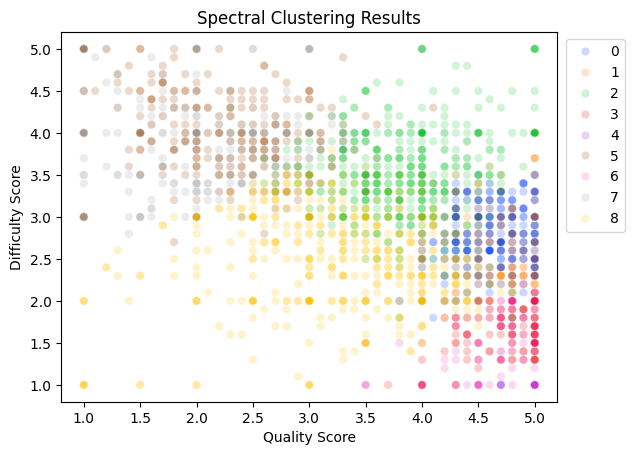

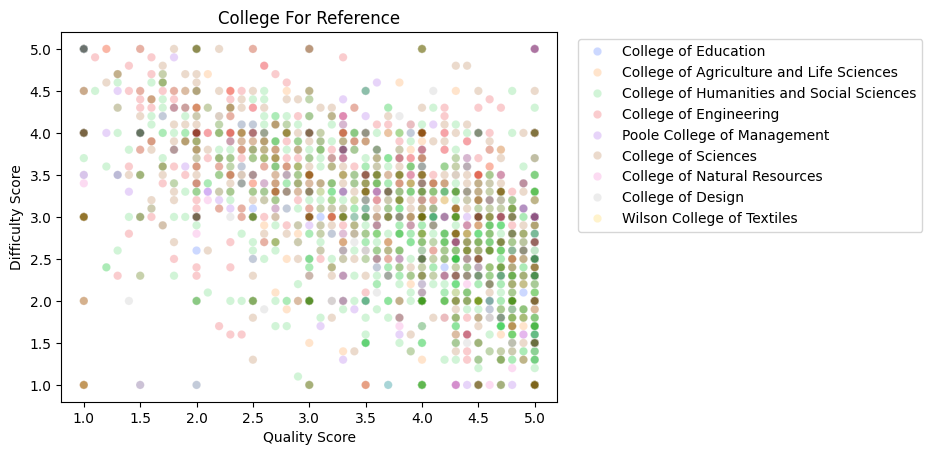

In [31]:
# Run the Best Spectral Clustering Estimator
best_spectral = Pipeline([('scaler', StandardScaler()), ('sc', SpectralClustering(n_clusters=9, eigen_solver='arpack', affinity='nearest_neighbors', random_state=random_seed))])
output = best_spectral.fit_predict(X)
sns.scatterplot(x=X['Quality Score'], y=X['Difficulty Score'], hue=output, palette='bright', alpha=0.2)
plt.legend(bbox_to_anchor=(1.15, 1), loc='upper right')
plt.title("Spectral Clustering Results")
plt.xlabel("Quality Score")
plt.ylabel("Difficulty Score")
plt.show()

# Plot of Colleges For Reference
sns.scatterplot(x=X['Quality Score'], y=X['Difficulty Score'], hue=y, palette='bright', alpha=0.2)
plt.legend(bbox_to_anchor=(1.75, 1), loc='upper right')
plt.title("College For Reference")
plt.xlabel("Quality Score")
plt.ylabel("Difficulty Score")
plt.show()

#### Affinity Propagation

In [33]:
# Affinity Propagation
affinity_pipeline = Pipeline([('scaler', StandardScaler()), ('ap', AffinityPropagation(random_state=random_seed))])
param_grid = {
    "ap__damping": [0.5, 0.6, 0.7, 0.8, 0.9]
}
grid_search = GridSearchCV(affinity_pipeline, param_grid, scoring=make_scorer(silhouette_scorer))
grid_search.fit(X)

KeyboardInterrupt: 

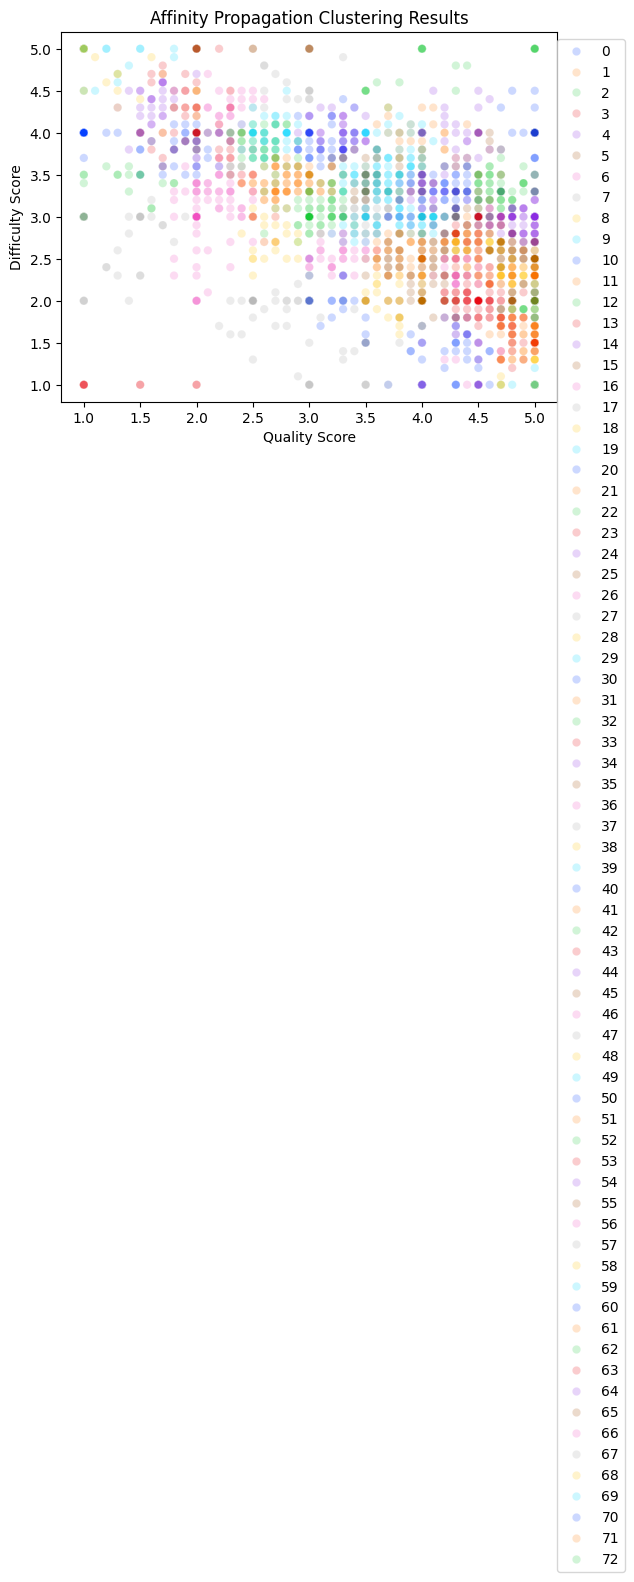

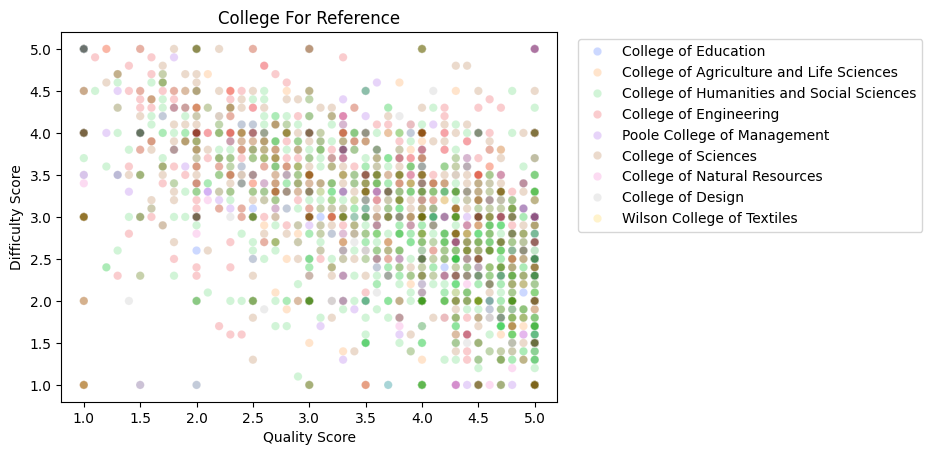

In [29]:
# Run the Best Affinity Propagation Clustering Estimator
best_affinity = AffinityPropagation(random_state=random_seed)
output = best_affinity.fit_predict(X)
sns.scatterplot(x=X['Quality Score'], y=X['Difficulty Score'], hue=output, palette='bright', alpha=0.2)
plt.legend(bbox_to_anchor=(1.15, 1), loc='upper right')
plt.title("Affinity Propagation Clustering Results")
plt.xlabel("Quality Score")
plt.ylabel("Difficulty Score")
plt.show()

# Plot of Colleges For Reference
sns.scatterplot(x=X['Quality Score'], y=X['Difficulty Score'], hue=y, palette='bright', alpha=0.2)
plt.legend(bbox_to_anchor=(1.75, 1), loc='upper right')
plt.title("College For Reference")
plt.xlabel("Quality Score")
plt.ylabel("Difficulty Score")
plt.show()

#### KMeans

In [ ]:
# KMeans
kmeans_pipeline = Pipeline(['km', KMeans(random_state=random_seed)])
kmeans_param_grid = {
    "knn__n_neighbors": [1,3,5,7,10]
}

#### Mini Batch KMeans

In [ ]:
# Mini Batch KMeans
mini_batch_kmeans_pipeline = Pipeline(['mbkm', MiniBatchKMeans(random_state=random_seed)])
mb_kmeans_param_grid = {
    "knn__n_neighbors": [1,3,5,7,10]
}

#### Agglomerative Clustering

In [ ]:
# Agglomerative Clustering
agglo_cluster_pipeline = Pipeline(['ac', AgglomerativeClustering(random_state=random_seed)])
agglo_param_grid = {
    "knn__n_neighbors": [1,3,5,7,10]
}

#### Gaussian Mixtures

In [ ]:
# Gaussian Mixtures
gaussian_pipeline = Pipeline(['ga', GaussianMixture(random_state=random_seed)])
gaussian_param_grid = {
    "knn__n_neighbors": [1,3,5,7,10]
}

### 4. Visualization
This stage involves generating visuals to analyze and find patterns in the data.

In [ ]:
# TODO: Visualize data points and rating distributions for each college individually
# TODO: Visualize aggregation + average of data points and rating distributions for all colleges
# TODO: Visualize 

### 5. Interpretation
This stage involves computing metrics to drive insights about the data.

In [ ]:
# TODO: Calculate and compare weighted averages of ratings for each college, compare to global averages
# TODO: Calculate metrics like standard deviation, median, outliers, for each college and globally
# TODO: Compare expected salary with average ratings for each college